In [12]:
#Gives sum of next 30 days output expected
#Try add two years ago as well and see what happens. 
#Add more statistics
#Try polynomial predictor and try LSTM see what happens. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)
from sklearn.ensemble import GradientBoostingRegressor


In [13]:
electricity_ng = pd.read_csv('Dataset/PV_Elec_Gas2.csv').rename(columns={'Unnamed: 0': 'Date'})
solar_output = pd.read_csv('Dataset/solarpower_cumuldaybyday2.csv').drop(columns='Unnamed: 2')


In [14]:
def get_month(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    month = date.month
    return month
def get_yr(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    year = date.year
    return year
def get_day(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    day = date.day
    return day

def days_change(x,y):
    date_1 = datetime.strptime(x, "%Y-%m-%d")
    date_2 = datetime.strptime(y, "%Y-%m-%d")
    chng = (date_2 - date_1).days
    return chng

electricity_ng['month'] = electricity_ng['Date'].apply(get_month)
electricity_ng['year'] = electricity_ng['Date'].apply(get_yr)
electricity_ng['yesterday_power'] = electricity_ng['cum_power'].shift(1)
electricity_ng['yesterday'] = electricity_ng['Date'].shift(1)
electricity_ng = electricity_ng.dropna()
electricity_ng
electricity_ng['days'] = electricity_ng.apply(lambda x: days_change(x['yesterday'], x['Date']),axis=1)
electricity_ng['output/day'] = (electricity_ng['cum_power'] - electricity_ng['yesterday_power'])/electricity_ng['days']
electricity_ng['day_of_month'] = electricity_ng['Date'].apply(get_day)



analyze = electricity_ng[['Date','year', 'month', 'day_of_month', 'output/day']]
analyze['target'] = analyze['output/day'].shift(-1)
analyze['target'] = analyze['target'].shift(-30).rolling(window=30).sum()
#analyze

#analyze.to_csv('check.csv')



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
def mv_avg(df):
    mvg_avg_lst = [2,3,4,5,7,10,15,20,25,30,45]
    for i in mvg_avg_lst:
        column_name = 'mv_avg_' + str(i)
        df[column_name] = df.iloc[:,4].rolling(window=i).mean()
    return df
# df = mv_avg(analyze)
# df[df['year']==2013]


In [16]:
#Get moving average this time last year and 1 year before for each date
def year_over_yr(data):
    yr = 2011
    yrs = {}
    target = data[['year', 'month', 'day_of_month', 'target']].copy()
    data = data.drop(columns ='target')
    for i in range(0, (max(data['year']) - yr) + 1):
        frame_name = 'year' + str(yr) + 'data' 
        yrs[frame_name] = data[data['year']==yr]
        yr +=1

    
    #Get_last year
    data_set = {}
    for item in [2013,2014,2015,2016,2017,2018,2019]:
        last_yr = item-1
        lst_yr = 'year' + str(last_yr) + 'data' 
        this_yr = 'year' + str(item) + 'data' 
        
        data_last_year = yrs[lst_yr]
        
        
        for column in data_last_year.columns:
            if 'mv_avg' in column:
                data_last_year = data_last_year.rename(columns={column: 'lst_yr_' + str(column)})

        data_this_year = yrs[this_yr]
        iter_frame = pd.DataFrame()
        data_last_year = data_last_year.drop(columns=['Date', 'year', 'output/day'])
        data_this_year =  data_this_year.drop(columns=['Date', 'year'])
        iter_frame = pd.merge(data_this_year,data_last_year, on =['month', 'day_of_month'], how='left')
        iter_frame.insert(0, 'year', item)
        
        data_set[item] = iter_frame

    final_frame = pd.DataFrame()
    i = 0
    for item in data_set.keys():
        if i == 0:
            final_frame = data_set[item]    
            i+=1
            continue
        final_frame = final_frame.append(data_set[item])
  
    final_frame = pd.merge(final_frame,target, on =['year', 'month', 'day_of_month'],how='left')
    final_frame = final_frame.sort_values(by=['year', 'month', 'day_of_month'], ascending=True)
    return final_frame


# df1 = year_over_yr(df)
# df1[(df1['month']==1) & (df1['year']==2013)]


In [17]:
def past_performance(DF):
    past_performance = DF[['year', 'month', 'day_of_month', 'target']]
    past_performance['year+1'] = past_performance['year'] + 1
    past_performance = past_performance[past_performance['year']!=2011]
    past_stats = {}
    for year in list(set(past_performance['year'])):
        if year not in [2011,2012]:
            Frame_name = str(year) + '_pd'
            iter_frame = past_performance[past_performance['year']<year]
            past_stats_df = iter_frame[~(iter_frame['target'].isna())].groupby(['month', 'day_of_month'])['target'].agg(['mean', 'std']).reset_index()
            last_year = year -1
            last_year_data = iter_frame[iter_frame['year']==last_year]
            last_year_data = last_year_data[['month', 'day_of_month', 'target']]
            last_year_data = last_year_data.rename(columns={'target': 'last_year'})
            put_together = pd.merge(past_stats_df, last_year_data, on =['month', 'day_of_month'],how='left')
            put_together.insert(0, 'year', year)
            #put_together['std'] = put_together['std'].fillna
            past_stats[Frame_name] = put_together
            
    return_this = pd.DataFrame()
    for key in past_stats:
        return_this = return_this.append(past_stats[key])
    return return_this

past_performance(DF=analyze)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


year  month  day_of_month        mean         std  last_year
0    2016      1             1   73.300000    9.265348       73.0
1    2016      1             2   73.525000   12.071281       69.0
2    2016      1             3   76.825000   13.649512       67.0
3    2016      1             4   80.300000   13.002307       72.0
4    2016      1             5   84.750000   13.167257       76.0
5    2016      1             6   88.125000   13.194285       78.0
6    2016      1             7   91.825000   12.312155       84.0
7    2016      1             8   93.875000   11.226568       88.0
8    2016      1             9   98.225000   12.485291       92.0
9    2016      1            10   99.400000   13.103689       93.0
10   2016      1            11  101.650000   17.184004       91.0
11   2016      1            12  102.775000   19.709621       94.0
12   2016      1            13  103.900000   18.771965      101.0
13   2016      1            14  106.950000   17.189435      107.0
14   2016      1            15  108.025000   16.456078      110.0
15   2016      1            16  110.900000   12.797396      115.0
16   2016      1            17  113.000000    9.282241      116.0
17   2016      1            18  116.675000    9.388424      120.0
18   2016      1            19  120.250000    8.808140      126.0
19   2016      1            20  124.475000    9.314997      128.0
20   2016      1            21  128.350000   13.320035      126.0
21   2016      1            22  131.575000   12.310531      130.0
22   2016      1            23  134.850000   11.726182      136.0
23   2016      1            24  136.775000   10.764254      139.0
24   2016      1            25  139.500000   10.598742      143.0
25   2016      1            26  143.025000   13.304229      145.0
26   2016      1            27  145.100000   10.067439      144.0
27   2016      1            28  147.125000   12.929392      155.0
28   2016      1            29  149.650000   14.179445      163.0
29   2016      1            30  151.050000   17.718070      169.0
30   2016      1            31  152.875000   17.139696      172.0
31   2016      2             1  154.050000   15.959637      174.0
32   2016      2             2  156.725000   15.426681      178.0
33   2016      2             3  161.900000   15.944278      184.0
34   2016      2             4  164.525000   17.408307      183.0
35   2016      2             5  167.725000   20.877640      192.0
36   2016      2             6  170.825000   27.177488      198.0
37   2016      2             7  175.625000   30.493538      202.0
38   2016      2             8  179.425000   37.970021      212.0
39   2016      2             9  185.825000   46.029148      227.0
40   2016      2            10  195.400000   53.255860      242.0
41   2016      2            11  203.450000   53.936042      255.0
42   2016      2            12  207.850000   53.527905      253.0
43   2016      2            13  209.100000   49.705667      247.0
44   2016      2            14  220.175000   51.585940      257.0
45   2016      2            15  225.300000   50.017197      263.0
46   2016      2            16  226.825000   45.445379      265.0
47   2016      2            17  230.050000   44.253550      262.0
48   2016      2            18  235.375000   48.331106      258.0
49   2016      2            19  241.250000   48.724292      263.0
50   2016      2            20  250.050000   53.125418      276.0
51   2016      2            21  255.425000   55.020383      285.0
52   2016      2            22  258.825000   56.853518      286.0
53   2016      2            23  264.025000   53.973473      281.0
54   2016      2            24  274.000000   47.193290      280.0
55   2016      2            25  285.675000   41.471064      294.0
56   2016      2            26  292.325000   43.460892      293.0
57   2016      2            27  298.750000   48.359659      283.0
58   2016      2            28  306.275000   50.570438      289.0
59   2016      2            29  335.400000   

In [56]:
def day_dums(data):

    data = data[data['year']> 2012]
    day = [0,10,15,31]
    day_buckets = pd.DataFrame()
    for j in range(0,len(day)):
        start = day[j]
        if j != len(day)-1:
            end = day[j+1]
        else:
            continue
        c_n = 'day>=_' + str(start)+ '_day_<' + str(end)
        day_buckets[c_n] = data.apply(lambda x: 1 if x['day_of_month'] >= start and x['day_of_month'] < end else 0,axis=1)
    day_buckets
    pd.set_option('display.max_rows',300)
    dummies = day_buckets
    merger_data = data[['year', 'month', 'day_of_month']]
    month_dummies = pd.get_dummies(data[data['year']>2012]['month'])
    Trans_frm = merger_data.join(month_dummies)
    Trans_frm = Trans_frm.join(dummies)
    
    return Trans_frm




In [208]:
def pipeline(dataframe):
    dummies = day_dums(dataframe)
    T_1 = mv_avg(dataframe)
    T_2 = year_over_yr(T_1)
    T = pd.merge(dummies, T_2, on=['year', 'month', 'day_of_month'],how='outer')
    past_data = past_performance(DF=analyze)
    T = pd.merge(T, past_data, on =['year','month', 'day_of_month'])
    return T
pd.set_option("display.max_rows",300)


data = pipeline(analyze)
data = data[~(data['std'].isna())]
#display(data.head(5))


train = data[data['year'] < 2019]
train.to_csv('model_data/train.csv')
train = train[(train['month']!=2) | (train['day_of_month']!= 29)]
test = data[data['year']==2019]
test.to_csv('model_data/test.csv')
train[pd.isnull(train).any(axis=1)]
y = train.pop('target')
train
Stats = train.describe()
Stats = Stats.transpose()
train = train.drop(columns=['year', 'month', 'day_of_month'])


# train = (train - Stats['mean'])/Stats['std']
# train = train.drop(columns=['year', 'month', 'day_of_month'])


#train

# from sklearn.preprocessing import MinMaxScaler


# scaler = MinMaxScaler()


# train = scaler.fit_transform(train)
train

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1  2  3  4  5  6  7  8  9  10  11  12  day>=_0_day_<10  \
365   1  0  0  0  0  0  0  0  0   0   0   0                1   
366   1  0  0  0  0  0  0  0  0   0   0   0                1   
367   1  0  0  0  0  0  0  0  0   0   0   0                1   
368   1  0  0  0  0  0  0  0  0   0   0   0                1   
369   1  0  0  0  0  0  0  0  0   0   0   0                1   
...  .. .. .. .. .. .. .. .. ..  ..  ..  ..              ...   
2186  0  0  0  0  0  0  0  0  0   0   0   1                0   
2187  0  0  0  0  0  0  0  0  0   0   0   1                0   
2188  0  0  0  0  0  0  0  0  0   0   0   1                0   
2189  0  0  0  0  0  0  0  0  0   0   0   1                0   
2190  0  0  0  0  0  0  0  0  0   0   0   1                0   

      day>=_10_day_<15  day>=_15_day_<31  output/day  mv_avg_2  mv_avg_3  \
365                  0                 0         2.0       2.0  2.666667   
366                  0                 0         3.0       2.5  2.333333   
367                  0                 0         2.0       2.5  2.333333   
368                  0                 0         3.0       2.5  2.666667   
369                  0                 0         1.0       2.0  2.000000   
...                ...               ...         ...       ...       ...   
2186                 0                 1         4.0       4.0  3.666667   
2187                 0                 1         2.0       3.0  3.333333   
2188                 0                 1         1.0       1.5  2.333333   
2189                 0                 1         1.0       1.0  1.333333   
2190                 0                 0         1.0       1.0  1.000000   

      mv_avg_4  mv_avg_5  mv_avg_7  mv_avg_10  mv_avg_15  mv_avg_20  \
365       2.75       2.4  2.571429       2.10   2.466667       2.80   
366       2.75       2.8  2.714286       2.30   2.600000       2.80   
367       2.25       2.6  2.428571       2.32   2.466667       2.65   
368       2.50       2.4  2.714286       2.60   2.400000       2.55   
369       2.25       2.2  2.428571       2.50   2.133333       2.50   
...        ...       ...       ...        ...        ...        ...   
2186      2.75       2.8  2.285714       2.50   2.533333       2.40   
2187      3.25       2.6  2.428571       2.20   2.333333       2.45   
2188      2.75       2.8  2.428571       2.10   2.133333       2.45   
2189      2.00       2.4  2.142857       2.00   2.133333       2.40   
2190      1.25       1.8  2.285714       2.00   2.000000       2.30   

      mv_avg_25  mv_avg_30  mv_avg_45  lst_yr_mv_avg_2  lst_yr_mv_avg_3  \
365        3.00   3.033333   2.777778             1.75         2.133333   
366        3.04   3.000000   2.822222             1.90         2.066667   
367        3.04   2.900000   2.822222             2.55         2.066667   
368        2.96   2.966667   2.866667             1.50         1.900000   
369        2.80   2.966667   2.844444             0.50         1.133333   
...         ...        ...        ...              ...              ...   
2186       2.16   2.166667   2.622222             1.00         1.000000   
2187       2.16   2.133333   2.622222             1.50         1.333333   
2188       2.16   2.133333   2.511111             2.50         2.000000   
2189       2.12   2.100000   2.422222             1.50         1.666667   
2190       2.12   2.000000   2.311111             0.50         1.333333   

      lst_yr_mv_avg_4  lst_yr_mv_avg_5  lst_yr_mv_avg_7  lst_yr_mv_avg_10  \
365             1.850             1.76         1.785714              1.49   
366             2.275             2.02         1.857143              1.74   
367             2.150             2.30         1.985714              1.95   
368             1.700             1.84         1.871429              1.82   
369             1.525             1.44         1.785714              1.64   
...               ...              ...              ...               ...   
2186            0.750          

In [209]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm


x = train.values

C=[.001,.005,.007,.0007]
# for c in C:
svc = svm.SVC(kernel='linear',C=0.0007 , degree=3, shrinking=False, verbose=True, max_iter=20)
mod = svc.fit(x, y)
print(mod.score(x, y))


#With linear coeff of determinaton = 0.95

[LibSVM]

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.08054794520547945


In [210]:
# test
actual = test.pop('target')
meta = test[['year', 'month', 'day_of_month']]
test = test.drop(columns=['year', 'month', 'day_of_month'])

pred = mod.predict(test.values)

In [211]:
anal_ize = pd.DataFrame()
anal_ize['actual'] = actual
anal_ize['predicted'] = pred
anal_ize['error'] = abs(anal_ize['actual'] -anal_ize['predicted'])
anal_ize = meta.join(anal_ize)
anal_ize['error'].sum()
anal_ize = anal_ize.dropna()
anal_ize

year  month  day_of_month  actual  predicted  error
2191  2019      1             1    65.0       63.0    2.0
2192  2019      1             2    66.0       63.0    3.0
2193  2019      1             3    65.0       63.0    2.0
2194  2019      1             4    67.0       63.0    4.0
2195  2019      1             5    69.0       98.0   29.0
2196  2019      1             6    71.0       98.0   27.0
2197  2019      1             7    72.0       98.0   26.0
2198  2019      1             8    76.0       98.0   22.0
2199  2019      1             9    73.0       99.0   26.0
2200  2019      1            10    75.0       99.0   24.0
2201  2019      1            11    75.0       99.0   24.0
2202  2019      1            12    79.0       99.0   20.0
2203  2019      1            13    86.0       99.0   13.0
2204  2019      1            14    92.0      126.0   34.0
2205  2019      1            15    99.0      126.0   27.0
2206  2019      1            16   107.0      115.0    8.0
2207  2019      1            17   114.0      115.0    1.0
2208  2019      1            18   119.0      115.0    4.0
2209  2019      1            19   122.0      115.0    7.0
2210  2019      1            20   126.0      119.0    7.0
2211  2019      1            21   131.0      119.0   12.0
2212  2019      1            22   136.0      119.0   17.0
2213  2019      1            23   138.0      119.0   19.0
2214  2019      1            24   147.0      119.0   28.0
2215  2019      1            25   154.0      119.0   35.0
2216  2019      1            26   163.0      119.0   44.0
2217  2019      1            27   173.0      119.0   54.0
2218  2019      1            28   181.0      119.0   62.0
2219  2019      1            29   179.0      119.0   60.0
2220  2019      1            30   180.0      176.0    4.0
2221  2019      1            31   181.0      176.0    5.0
2222  2019      2             1   181.0      193.0   12.0
2223  2019      2             2   186.0      193.0    7.0
2224  2019      2             3   192.0      193.0    1.0
2225  2019      2             4   196.0      193.0    3.0
2226  2019      2             5   200.0      193.0    7.0
2227  2019      2             6   206.0      193.0   13.0
2228  2019      2             7   206.0      193.0   13.0
2229  2019      2             8   212.0      193.0   19.0
2230  2019      2             9   218.0      193.0   25.0
2231  2019      2            10   221.0      193.0   28.0
2232  2019      2            11   224.0      193.0   31.0
2233  2019      2            12   222.0      193.0   29.0
2234  2019      2            13   216.0      193.0   23.0
2235  2019      2            14   211.0      193.0   18.0
2236  2019      2            15   215.0      193.0   22.0
2237  2019      2            16   220.0      193.0   27.0
2238  2019      2            17   217.0      193.0   24.0
2239  2019      2            18   218.0      193.0   25.0
2240  2019      2            19   228.0      193.0   35.0
2241  2019      2            20   236.0      193.0   43.0
2242  2019      2            21   233.0      260.0   27.0
2243  2019      2            22   250.0      260.0   10.0
2244  2019      2            23   249.0      260.0   11.0
2245  2019      2            24   253.0      260.0    7.0
2246  2019      2            25   249.0      260.0   11.0
2247  2019      2            26   245.0      260.0   15.0
2248  2019      2            27   255.0      260.0    5.0
2249  2019      2            28   270.0      350.0   80.0
2250  2019      3             1   282.0      328.0   46.0
2251  2019      3             2   301.0      350.0   49.0
2252  2019      3             3   309.0      350.0   41.0
2253  2019      3             4   317.0      350.0   33.0
2254  2019      3             5   318.0      350.0   32.0
2255  2019      3             6   326.0      350.0   24.0
2256  2019      3             7   333.0      335.0    2.0
2257  2019      3             8   340.0      335.0    5.0
2258  2019      3             9   347.0      335.0   12.0
2259

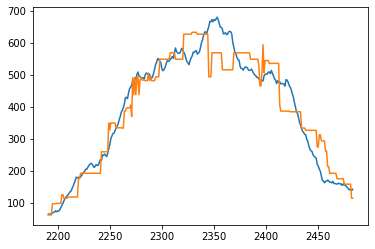

In [212]:
# x = anal_ize['actual']
x = anal_ize.index
y1 = anal_ize['actual']
y2 = anal_ize['predicted']
plt.plot(x,y1)
plt.plot(x,y2)

In [213]:
anal_ize['%err'] = anal_ize['error']/anal_ize['actual']
anal_ize['%err'].mean()
#anal_ize[anal_ize['month']==6]

0.12588441698760433